In [1]:
%%capture
!pip3 install pyproj
!pip3 install -U scikit-learn

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.neural_network import MLPRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score
import numpy as np
import os
from sklearn.feature_selection import SequentialFeatureSelector 
import preprocess
from combine_inventory_rasters import merge_inventory_rasters
import config as constants

inventory_data_dir = constants['INVENTORY_DATA_DIR']
merge_inventory_rasters(inventory_data_dir)

pd.options.display.width = 0
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

### Run

In [11]:
# Constants
seed=116
split_ratio = 0.85
k = 5
year = 2019
property_name = 'Clarion Junction'

inventory_df_fpath = './inventory_with_rasters.csv'
l2a_labelled_df_fpath = '/home/jovyan/work/tools/L2A_all_labeled.csv'

rh_cols = ['rh_05', 'rh_10', 'rh_15', "rh_20", 'rh_50', 'rh_95', 'rh_97', 'rh_98', 'rh_99', 'rh_100', 'rh_101']
categoricals = ['Property_', 'Strata_', 'Status_', 'Forest Type', 'Plot_', 'ForTyp', 'forest_type', 'forest_group']
columns_of_interest = ['Status_', 'ForTyp', 'Jenkins_Total_MTCO2e', 'biomass', 'forest_type', 'forest_group', 'precipitation', 
                       'temp','canopy_cover']

In [12]:
# Load TCF Data and Get Equidistant Projection
inv_df = pd.read_csv(inventory_df_fpath)
inv_df = inv_df.dropna()
inv_df = preprocess.get_equidistant_projection(inv_df)

# Load GEDI Data and Get Equidistant Projection
gedi_l2a = pd.read_csv(l2a_labelled_df_fpath)
gedi_l2a = preprocess.gediL2A_data_cleaning(gedi_l2a, rh_cols)
gedi_l2a = preprocess.get_equidistant_projection(gedi_l2a)

# Format TCF Data for One hot encoding
inv_prop_df = preprocess.tcf_format_columns(categoricals, columns_of_interest, inv_df)
inv_prop_df, gedi_l2a_df = preprocess.filter_data(inv_prop_df, gedi_l2a, property_name, year)

Len Before Format : 28
Len After Format : 95
Before:  8929
After:  4847


In [13]:
# Filter TCF and GEDI Columns
inv_prop_df = preprocess.tcf_filter_columns(columns_of_interest, inv_prop_df)
gedi_l2a = preprocess.gediL2A_filter_column(gedi_l2a, rh_cols)
print("TCF Count: ", len(inv_prop_df))
print("GEDI L2A Count: ", len(gedi_l2a))
kept_points, target_points = preprocess.get_tcf_train_test_split(inv_prop_df, split_ratio, seed)

Len Before Filter : 95
Len After Filter : 77
TCF Count:  2703
GEDI L2A Count:  211091
Kept 2298, interpolating 405


In [14]:
train_df, test_df = preprocess.prepare_final_df(kept_points, target_points, gedi_l2a, rh_cols, k)
#dir_path = os.path.join('./../csv/', property_name.replace(' ', ''))
#os.mkdir(dir_path) if not os.path.exists(dir_path) else ''
#fpath = os.path.join(dir_path, 'csv')
#train_df.to_csv(os.path.join(dir_path, 'training.csv'))
#test_df.to_csv(os.path.join(dir_path, 'testing.csv'))

(2298, 441) (405, 441)


In [15]:
train_df[['tcf_distances_nn_1', 'tcf_distances_nn_2', 'tcf_distances_nn_3', 'tcf_distances_nn_4', 'tcf_distances_nn_5']]
#test_df[['gedi_distances_nn_1', 'gedi_distances_nn_2', 'gedi_distances_nn_3', 'gedi_distances_nn_4', 'gedi_distances_nn_5']]

tcf_distances_nn_1  tcf_distances_nn_2  tcf_distances_nn_3  tcf_distances_nn_4  tcf_distances_nn_5
0     241.308127          241.308207          311.377119          311.633952          311.633991        
1     197.012438          241.308950          241.309049          311.398273          311.398793        
2     197.012957          241.313786          311.406023          394.025671          394.026196        
3     197.014477          197.014621          241.310587          241.310611          311.402968        
4     197.012875          241.309137          241.309236          311.399430          311.399942        
...          ...                 ...                 ...                 ...                 ...        
2293  197.011210          241.306367          311.393519          311.637989          311.638118        
2294  120.660299          120.660388          197.025994          230.964395          231.109781        
2295  197.010209          241.309200          241.309298          311.396569          311.396951        
2296  197.005648          197.005897          241.311644          241.311824          311.395384        
2297  197.004097          241.311369          311.393095          311.393764          311.637190        

[2298 rows x 5 columns]

In [16]:
%%time
train = train_df.to_numpy()
train_X, train_y = train[:,1:], train[:,0]

test = test_df.to_numpy()
test_X, test_y = test[:,1:], test[:,0]

regr = MLPRegressor(random_state=116, max_iter=5, hidden_layer_sizes=(800,800,800)).fit(train_X, train_y)

CPU times: user 2min 23s, sys: 2min 36s, total: 4min 59s
Wall time: 4.77 s


In [17]:
sfs = SequentialFeatureSelector(regr)

In [18]:
predicted_sum = np.sum(regr.predict(test_X))

train_sum = np.sum(train_y)
test_sum = np.sum(test_y)

simple_mean = train_y.mean() * len(train_df)

print("Predicted Part:", predicted_sum)
print("Test Part:", test_sum)
print("Actual Sum for Property:", test_sum + train_sum)
print("Estimate Sum for Property:", predicted_sum + train_sum)

Predicted Part: 60442.319950646066
Test Part: 58153.42839191605
Actual Sum for Property: 402737.0287396856
Estimate Sum for Property: 405025.92029841564


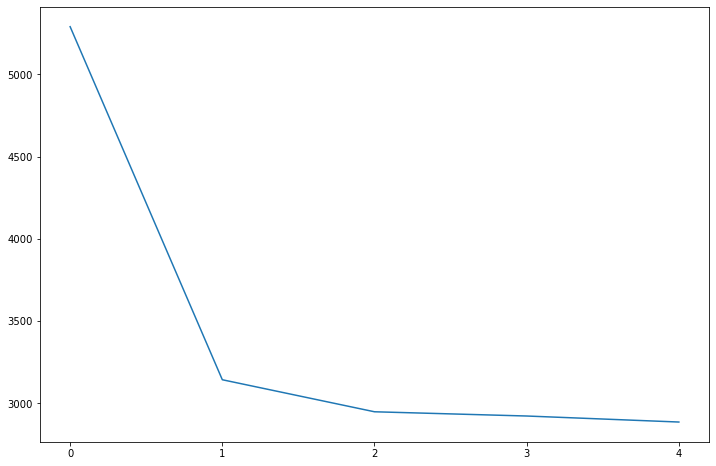

2887.207974799089
2887.207974799089
5


In [19]:
plt.figure(figsize=(12,8))
plt.plot(regr.loss_curve_)
plt.xticks(range(0, regr.n_iter_))
plt.show()
print(min(regr.loss_curve_))
print(regr.loss_)
print(regr.n_iter_)

# Test Set Metrics

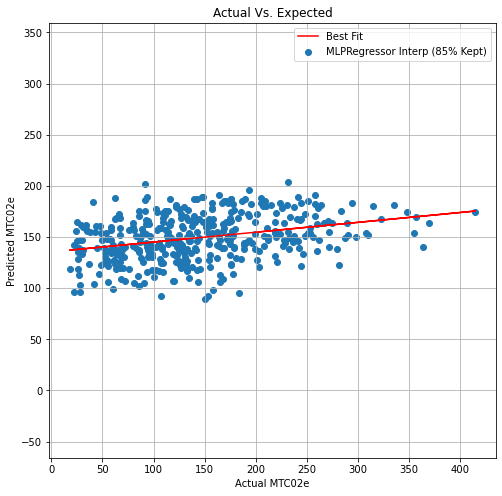

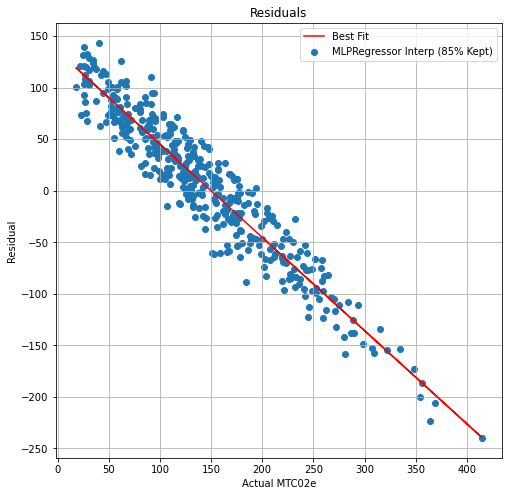

R2 Score: 0.09386910897445466
MAE: 56.629625111515885
Explained Variance: 0.0997337712065588


In [20]:
y_hat =  regr.predict(test_X)
x = test_y
m, b = np.polyfit(x, y_hat, 1)

fig = plt.figure(figsize=(8,8))
plt.axis('equal')
plt.grid()
fig.set_facecolor("#FFFFFF")
plt.title("Actual Vs. Expected")
plt.scatter(x, y_hat, label="MLPRegressor Interp (85% Kept)")
plt.plot(x, m*x+b, c="red", label="Best Fit")
plt.xlabel('Actual MTC02e')
plt.ylabel('Predicted MTC02e')
plt.legend()
plt.show()

y_res =  regr.predict(test_X) - test_y
x = test_y
m, b = np.polyfit(x, y_res, 1)

fig = plt.figure(figsize=(8,8))
#plt.axis('equal')
plt.grid()
fig.set_facecolor("#FFFFFF")
plt.title("Residuals")
plt.scatter(x, y_res, label="MLPRegressor Interp (85% Kept)")
plt.plot(x, m*x+b, c="red", label="Best Fit")
plt.xlabel('Actual MTC02e')
plt.ylabel('Residual')
plt.legend()
plt.show()

print("R2 Score:", r2_score(test_y, regr.predict(test_X)))
print("MAE:", mean_absolute_error(test_y, regr.predict(test_X)))
print("Explained Variance:", explained_variance_score(test_y, regr.predict(test_X)))

# Training Set Metrics

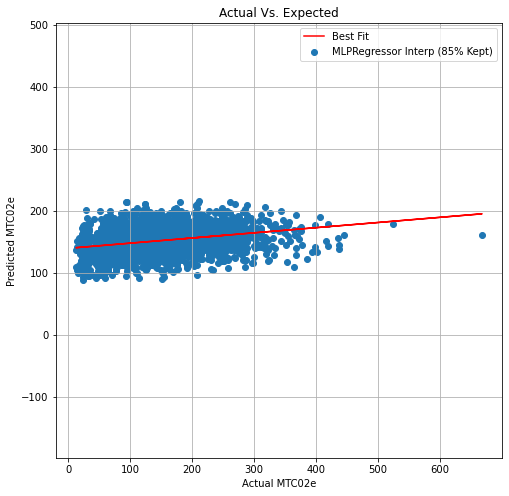

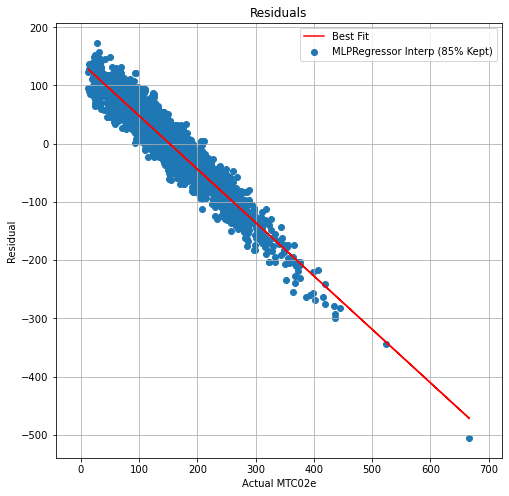

R2 Score: 0.08511226066021793
MAE: 60.21799284643356
Explained Variance: 0.08576649652168589


In [21]:
y_hat =  regr.predict(train_X)
x = train_y
m, b = np.polyfit(x, y_hat, 1)

fig = plt.figure(figsize=(8,8))
plt.axis('equal')
plt.grid()
fig.set_facecolor("#FFFFFF")
plt.title("Actual Vs. Expected")
plt.scatter(x, y_hat, label="MLPRegressor Interp (85% Kept)")
plt.plot(x, m*x+b, c="red", label="Best Fit")
plt.xlabel('Actual MTC02e')
plt.ylabel('Predicted MTC02e')
plt.legend()
plt.show()

y_res =  regr.predict(train_X) - train_y
x = train_y
m, b = np.polyfit(x, y_res, 1)

fig = plt.figure(figsize=(8,8))
plt.axis('equal')
plt.grid()
fig.set_facecolor("#FFFFFF")
plt.title("Residuals")
plt.scatter(x, y_res, label="MLPRegressor Interp (85% Kept)")
plt.plot(x, m*x+b, c="red", label="Best Fit")
plt.xlabel('Actual MTC02e')
plt.ylabel('Residual')
plt.legend()
plt.show()

print("R2 Score:", r2_score(train_y, regr.predict(train_X)))
print("MAE:", mean_absolute_error(train_y, regr.predict(train_X)))
print("Explained Variance:", explained_variance_score(train_y, regr.predict(train_X)))